# Meta Prompting: A Guide to Automated Prompt Optimization

This Cookbook is available on openai.com at https://cookbook.openai.com/examples/enhance_your_prompts_with_meta_prompting

Welcome to our cookbook on meta prompting! In this guide, we'll explore how to take a basic prompt and refine it to enhance the quality of outputs from a language model. We'll use the example of summarizing news reports to illustrate the process.


Meta-prompting is a technique where you use an LLM to generate or improve prompts. Typically this is done using a higher intelligence model that optimizes prompts for a model with less intelligence. It’s a process of using prompts to guide, structure, and optimize other prompts, helping ensure they’re more effective in guiding the LLM towards high-quality, relevant outputs. We'll be leveraging the capabilities of `o1-preview`, a more intelligent model with advanced reasoning skills, to improve a prompt for `gpt-4o`.

We're committed to making your development journey with LLMs smoother and more accessible through this technique. Don't forget to check out our [Generate Anything](https://platform.openai.com/docs/guides/prompt-generation) feature in the playground — it's a fantastic starting point to dive into meta prompting.

In this example, we'll begin with a simple prompt for summarizing news articles and then enhance it to see how the outputs improve. We'll use `o1-preview` to analyze and refine our prompt, adding more detail and clarity along the way. Finally, we'll evaluate the outputs systematically to understand the impact of our refinements.

In [ ]:
%pip install -qq pandas datasets openai python-dotenv

In [2]:
import pandas as pd
import os
from openai import AzureOpenAI
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from pydantic import BaseModel
from datasets import load_dataset
from dotenv import load_dotenv

%reload_ext dotenv
load_dotenv(".env")

# Azure OpenAI
api_type: str = "azure"
api_key = os.getenv("KEY")
api_base = os.getenv("ENDPOINT")
api_version = "2024-08-01-preview"
model = "4o"

client = AzureOpenAI(
    api_key=api_key,
    api_version=api_version,
    base_url=f"{api_base}/openai/deployments/{model}",
)

## Importing the Data

Let's kick things off by importing the `bbc_news_alltime` dataset from [HuggingFace](https://huggingface.co/datasets/RealTimeData/bbc_news_alltime). This dataset contains all BBC News articles, capturing everything published monthly from 2017 up to the latest complete month. For our experiment, we'll focus exclusively on a sample from a recent month—August 2024—to keep things current and manageable.


In [3]:
ds = load_dataset("RealTimeData/bbc_news_alltime", "2024-08")
df = pd.DataFrame(ds['train']).sample(n=10, random_state=0)
df.head()

,title,published_date,authors,description,section,content,link,top_image
2712,BBC News Daily,2024-08-05,None,Get our flagship daily newsletter delivered st...,None,Get our flagship daily newsletter delivered st...,http://www.bbc.co.uk/newsletters/bbcnewsemails...,https://ichef.bbci.co.uk/images/ic/960xn/p0fdk...
2751,Olympics: GB's Amber Anning and Laviai Nielsen...,2024-08-05,None,GB's Laviai Nielsen and Amber Anning progress ...,None,Team GB's Laviai Nielsen and Amber Anning prog...,http://www.bbc.co.uk/sport/olympics/videos/cvg...,https://ichef.bbci.co.uk/ace/standard/1024/cps...
2438,Hundreds of thousands of dragonflies swarm bea...,2024-08-03,None,Social media videos show the harmless insects ...,None,"""It is unbelievable,"" says one beach goer as t...",http://www.bbc.co.uk/news/videos/c80xk751zdzo,https://ichef.bbci.co.uk/news/1024/branded_new...
92,The Hundred 2024 LIVE: Southern Brave vs Manch...,2024-08-01,https://www.facebook.com/BBCSport/,Southern Brave face Manchester Originals in th...,None,,http://www.bbc.co.uk/sport/cricket/live/c2qq74...,https://static.files.bbci.co.uk/ws/simorgh-ass...
569,CCTV captures moment 4.4 magnitude earthquake ...,2024-08-14,None,"The quake shook homes and startled residents, ...",None,A 4.4 magnitude earthquake shook homes and sta...,http://www.bbc.co.uk/news/videos/cy8x7xq0ejeo,https://ichef.bbci.co.uk/news/1024/branded_new...


## Iterating on Prompts


Let's start with a straightforward prompt and then use GPT-4o to enhance it for better results. We want to summarize news articles, so this is what i'll ask the model to do. 

In [4]:
simple_prompt = "Summarize this news article: {article}"


To improve the prompt, we need to provide the model with the context and goals we want to achieve. We can then ask it to generate a more detailed prompt that would produce richer and more comprehensive news summaries.

In [21]:
meta_prompt = """
Improve the following prompt to generate a more detailed summary. 
Use prompt engineering best practices. 
Make sure the structure is clear and intuitive and contains the type of news, tags and sentiment analysis.
Only return the improved prompt.

{simple_prompt}
"""

In [22]:
def get_model_response(messages, model="4o"):
    response = client.chat.completions.create(
        messages=messages,
        model=model
    )
    return response.choices[0].message.content


complex_prompt = get_model_response(
    [{"role": "user", "content": meta_prompt.format(simple_prompt=simple_prompt)}])
print(complex_prompt)

Please provide a comprehensive summary of the news article: {article}. Ensure that the summary includes the following details:

1. **Type of News**: Clearly categorize the news type (e.g., political, economic, science, entertainment, etc.).

2. **Main Points**: Highlight the key points, events, or developments discussed in the article with a clear and concise structure.

3. **Tags**: Suggest relevant tags or keywords associated with the article content.

4. **Sentiment Analysis**: Analyze and describe the overall sentiment or tone of the article (e.g., positive, negative, neutral) and, if applicable, identify key phrases contributing to this sentiment.


## Generating the Summaries

Now that we have both prompts, let's generate the summaries! For each entry in our dataset, we'll use both the simple and the enhanced prompts to see how they compare. By doing this, we'll get a firsthand look at how our refinements with `GPT-4o` can lead to richer and more detailed summaries. Let's dive in and see the difference for ourselves!

In [23]:
def generate_response(prompt): 
    messages = [{"role": "user", "content": prompt}]
    response = get_model_response(messages, model="gpt-4o-mini")
    return response

def generate_summaries(row):
    simple_itinerary = generate_response(simple_prompt.format(article=row["content"]))
    complex_itinerary = generate_response(complex_prompt + row["content"])
    return simple_itinerary, complex_itinerary

Let's check if everything looks good and if we can generate a summary for the first news report. 

In [24]:
generate_summaries(df.iloc[1])

("In the recent Olympic qualifiers, Team GB's Laviai Nielsen and Amber Anning successfully advanced to the semi-finals of the women's 400m event. However, their teammate Victoria Ohuruogu did not qualify directly and will need to compete in the repechage round to secure her spot for the Paris 2024 Olympics.",
 '**Type of News**: Sports\n\n**Main Points**:\n1. Laviai Nielsen and Amber Anning, representing Team GB, have successfully progressed to the semi-finals of the women\'s 400m race at Paris 2024.\n2. Victoria Ohuruogu, another competitor from Team GB, did not directly qualify for the semi-finals and will compete in the repechage round for a chance to secure her place.\n3. The article provides a brief mention of Olympic superstar Simone Biles and her upcoming participation in the floor final after experiencing a fall on the beam.\n\n**Tags**: Paris 2024, Team GB, Laviai Nielsen, Amber Anning, Victoria Ohuruogu, Women\'s 400m, Athletics, Olympics, Simone Biles\n\n**Sentiment Analysis

By comparing the summaries generated from the simple and enhanced prompts, we can already see significant improvements. The initial summary gives us a general overview of the article, whereas the enhanced summary dives deeper — it not only provides a detailed summary but also categorizes the news type, lists relevant tags, and even includes a sentiment analysis.

Let's test on the entire dataset now! 

In [25]:
# Add new columns to the dataframe for storing itineraries
df['simple_summary'] = None
df['complex_summary'] = None

# Use ThreadPoolExecutor to generate itineraries concurrently
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(generate_summaries, row): index for index, row in df.iterrows()}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Generating Itineraries"):
        index = futures[future]
        simple_itinerary, complex_itinerary = future.result()
        df.at[index, 'simple_summary'] = simple_itinerary
        df.at[index, 'complex_summary'] = complex_itinerary

df.head()

Generating Itineraries: 100%|█████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.94s/it]


,title,published_date,authors,description,section,content,link,top_image,simple_summary,complex_summary
2712,BBC News Daily,2024-08-05,None,Get our flagship daily newsletter delivered st...,None,Get our flagship daily newsletter delivered st...,http://www.bbc.co.uk/newsletters/bbcnewsemails...,https://ichef.bbci.co.uk/images/ic/960xn/p0fdk...,The news article promotes a daily newsletter s...,"I’m sorry, but I cannot provide a summary with..."
2751,Olympics: GB's Amber Anning and Laviai Nielsen...,2024-08-05,None,GB's Laviai Nielsen and Amber Anning progress ...,None,Team GB's Laviai Nielsen and Amber Anning prog...,http://www.bbc.co.uk/sport/olympics/videos/cvg...,https://ichef.bbci.co.uk/ace/standard/1024/cps...,Team GB athletes Laviai Nielsen and Amber Anni...,Certainly! Below is a comprehensive summary of...
2438,Hundreds of thousands of dragonflies swarm bea...,2024-08-03,None,Social media videos show the harmless insects ...,None,"""It is unbelievable,"" says one beach goer as t...",http://www.bbc.co.uk/news/videos/c80xk751zdzo,https://ichef.bbci.co.uk/news/1024/branded_new...,Thousands of harmless dragonflies swarmed Misq...,"Based on the information provided, here's a su..."
92,The Hundred 2024 LIVE: Southern Brave vs Manch...,2024-08-01,https://www.facebook.com/BBCSport/,Southern Brave face Manchester Originals in th...,None,,http://www.bbc.co.uk/sport/cricket/live/c2qq74...,https://static.files.bbci.co.uk/ws/simorgh-ass...,Of course! Please provide the text or main poi...,To provide a comprehensive summary of the arti...
569,CCTV captures moment 4.4 magnitude earthquake ...,2024-08-14,None,"The quake shook homes and startled residents, ...",None,A 4.4 magnitude earthquake shook homes and sta...,http://www.bbc.co.uk/news/videos/cy8x7xq0ejeo,https://ichef.bbci.co.uk/news/1024/branded_new...,A 4.4 magnitude earthquake occurred in Califor...,**Type of News**: Science/Natural Disaster\n\n...


## Evaluating the Results

To assess the difference in performance between the two prompts, we'll use a structured evaluation approach with the LLM acting as a judge. This means we'll leverage the language model itself to evaluate and compare the outputs based on specific criteria.

**What Does "LLM as a Judge" Mean?**

Using an LLM as a judge involves having the language model evaluate its own outputs or those of another model. It applies predefined criteria to assess aspects like accuracy, clarity, and relevance. This approach helps us obtain an objective and consistent evaluation without human bias, making it easier to identify improvements between different prompts. Our cookbook on [Getting Started with OpenAI Evals](https://cookbook.openai.com/examples/evaluation/getting_started_with_openai_evals) offers a glimps on how you can get started with this approach.


Here's the prompt we'll use for evaluation:

In [26]:
evaluation_prompt = """
You are an expert editor tasked with evaluating the quality of a news article summary. Below is the original article and the summary to be evaluated:

**Original Article**:  
{original_article}

**Summary**:  
{summary}

Please evaluate the summary based on the following criteria, using a scale of 1 to 5 (1 being the lowest and 5 being the highest). Be critical in your evaluation and only give high scores for exceptional summaries:

1. **Categorization and Context**: Does the summary clearly identify the type or category of news (e.g., Politics, Technology, Sports) and provide appropriate context?  
2. **Keyword and Tag Extraction**: Does the summary include relevant keywords or tags that accurately capture the main topics and themes of the article?  
3. **Sentiment Analysis**: Does the summary accurately identify the overall sentiment of the article and provide a clear, well-supported explanation for this sentiment?  
4. **Clarity and Structure**: Is the summary clear, well-organized, and structured in a way that makes it easy to understand the main points?  
5. **Detail and Completeness**: Does the summary provide a detailed account that includes all necessary components (type of news, tags, sentiment) comprehensively?  


Provide your scores and justifications for each criterion, ensuring a rigorous and detailed evaluation.
"""

class ScoreCard(BaseModel):
    categorization: int
    keyword_extraction: int
    sentiment_analysis: int
    clarity_structure: int
    detail_completeness: int
    justification: str

Here's a pro tip — you can actually use meta prompting to refine your evaluation prompt as well! By applying the same iterative enhancement to the prompt that instructs the LLM to act as a judge, you can make your evaluations even more precise and insightful. 

Let's use this prompt to evaluate our summaries!

In [27]:
def evaluate_summaries(row):
    simple_messages = [{"role": "user", "content": evaluation_prompt.format(original_article=row["content"], summary=row['simple_summary'])}]
    complex_messages = [{"role": "user", "content": evaluation_prompt.format(original_article=row["content"], summary=row['complex_summary'])}]
    
    simple_summary = client.beta.chat.completions.parse(
        model="4o",
        messages=simple_messages,
        response_format=ScoreCard)
    simple_summary = simple_summary.choices[0].message.parsed
    
    complex_summary = client.beta.chat.completions.parse(
        model="4o",
        messages=complex_messages,
        response_format=ScoreCard)
    complex_summary = complex_summary.choices[0].message.parsed
    
    return simple_summary, complex_summary

# Add new columns to the dataframe for storing evaluations
df['simple_evaluation'] = None
df['complex_evaluation'] = None

# Use ThreadPoolExecutor to evaluate itineraries concurrently
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(evaluate_summaries, row): index for index, row in df.iterrows()}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Evaluating Summaries"):
        index = futures[future]
        simple_evaluation, complex_evaluation = future.result()
        df.at[index, 'simple_evaluation'] = simple_evaluation
        df.at[index, 'complex_evaluation'] = complex_evaluation

df.head()

Evaluating Summaries: 100%|███████████████████████████████████████████████████| 10/10 [00:32<00:00,  3.22s/it]


,title,published_date,authors,description,section,content,link,top_image,simple_summary,complex_summary,simple_evaluation,complex_evaluation
2712,BBC News Daily,2024-08-05,None,Get our flagship daily newsletter delivered st...,None,Get our flagship daily newsletter delivered st...,http://www.bbc.co.uk/newsletters/bbcnewsemails...,https://ichef.bbci.co.uk/images/ic/960xn/p0fdk...,The news article promotes a daily newsletter s...,"I’m sorry, but I cannot provide a summary with...",categorization=2 keyword_extraction=4 sentimen...,categorization=1 keyword_extraction=1 sentimen...
2751,Olympics: GB's Amber Anning and Laviai Nielsen...,2024-08-05,None,GB's Laviai Nielsen and Amber Anning progress ...,None,Team GB's Laviai Nielsen and Amber Anning prog...,http://www.bbc.co.uk/sport/olympics/videos/cvg...,https://ichef.bbci.co.uk/ace/standard/1024/cps...,Team GB athletes Laviai Nielsen and Amber Anni...,Certainly! Below is a comprehensive summary of...,categorization=4 keyword_extraction=3 sentimen...,categorization=5 keyword_extraction=5 sentimen...
2438,Hundreds of thousands of dragonflies swarm bea...,2024-08-03,None,Social media videos show the harmless insects ...,None,"""It is unbelievable,"" says one beach goer as t...",http://www.bbc.co.uk/news/videos/c80xk751zdzo,https://ichef.bbci.co.uk/news/1024/branded_new...,Thousands of harmless dragonflies swarmed Misq...,"Based on the information provided, here's a su...",categorization=3 keyword_extraction=4 sentimen...,categorization=5 keyword_extraction=5 sentimen...
92,The Hundred 2024 LIVE: Southern Brave vs Manch...,2024-08-01,https://www.facebook.com/BBCSport/,Southern Brave face Manchester Originals in th...,None,,http://www.bbc.co.uk/sport/cricket/live/c2qq74...,https://static.files.bbci.co.uk/ws/simorgh-ass...,Of course! Please provide the text or main poi...,To provide a comprehensive summary of the arti...,categorization=1 keyword_extraction=1 sentimen...,categorization=4 keyword_extraction=3 sentimen...
569,CCTV captures moment 4.4 magnitude earthquake ...,2024-08-14,None,"The quake shook homes and startled residents, ...",None,A 4.4 magnitude earthquake shook homes and sta...,http://www.bbc.co.uk/news/videos/cy8x7xq0ejeo,https://ichef.bbci.co.uk/news/1024/branded_new...,A 4.4 magnitude earthquake occurred in Califor...,**Type of News**: Science/Natural Disaster\n\n...,categorization=4 keyword_extraction=5 sentimen...,categorization=5 keyword_extraction=5 sentimen...


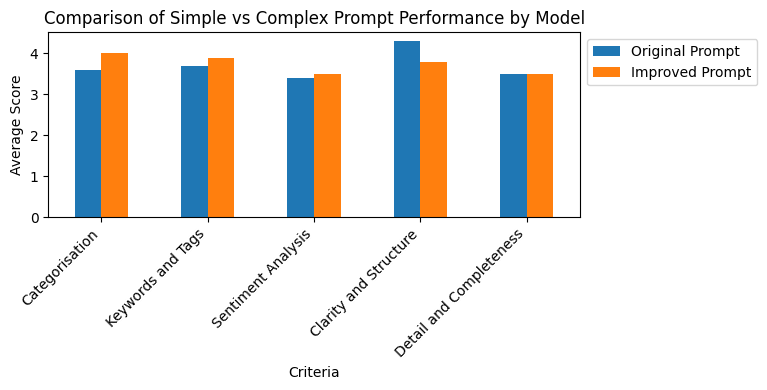

In [28]:
import matplotlib.pyplot as plt

df["simple_scores"] = df["simple_evaluation"].apply(lambda x: [score for key, score in x.model_dump().items() if key != 'justification'])
df["complex_scores"] = df["complex_evaluation"].apply(lambda x: [score for key, score in x.model_dump().items() if key != 'justification'])


# Calculate average scores for each criterion
criteria = [
    'Categorisation',
    'Keywords and Tags',
    'Sentiment Analysis',
    'Clarity and Structure',
    'Detail and Completeness'
]

# Calculate average scores for each criterion by model
simple_avg_scores = df['simple_scores'].apply(pd.Series).mean()
complex_avg_scores = df['complex_scores'].apply(pd.Series).mean()


# Prepare data for plotting
avg_scores_df = pd.DataFrame({
    'Criteria': criteria,
    'Original Prompt': simple_avg_scores,
    'Improved Prompt': complex_avg_scores
})

# Plotting
ax = avg_scores_df.plot(x='Criteria', kind='bar', figsize=(6, 4))
plt.ylabel('Average Score')
plt.title('Comparison of Simple vs Complex Prompt Performance by Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


After evaluating the results, we found that while the basic prompt performed well in clarity and structure, the enhanced prompt significantly improved outputs across several other key criteria: Categorization, Keywords and Tags, Sentiment Analysis, and Detail and Completeness. The complex prompt led to summaries that were more informative, better organized, and richer in content.

This demonstrates how refining prompts can greatly enhance the quality of the generated summaries. Although this is a simplified example, the benefits of prompt optimization are expected to be even more pronounced in real-world, production-level applications, leading to outputs that are more aligned with specific goals and user needs.

## Conclusion

Meta prompting is a powerful technique that can significantly enhance the quality of outputs from language models. Our exploration showed that starting with a simple prompt and refining it using `o1-preview` led to summaries that were more informative, better organized, and richer in content—improving across key criteria like categorization, keywords and tags, sentiment analysis, and completeness. This exercise underscores the value of prompt optimization, and even in this simplified example, the benefits are clear. In real-world applications, leveraging meta prompting and tools like `o1-preview` can elevate language model performance to better meet your specific goals and user needs.